# Hybrid Model

In [2]:
def lorenz_knowledge(x, y, z, a=10, b=28, c=2.667, error_param = 0.5, dt = 0.01):
    x_dot = a*(y - x)
    y_dot = b*(1 + error_param)*x - y - x*z
    z_dot = x*y - c*z
    return np.array((x + x_dot*dt, y + y_dot*dt, z + z_dot*dt))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

Computing spectral radius...
done.
nmse: [0.38213141 0.51936217 0.26482711]


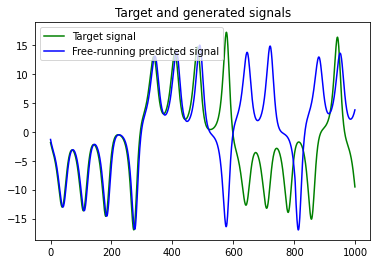

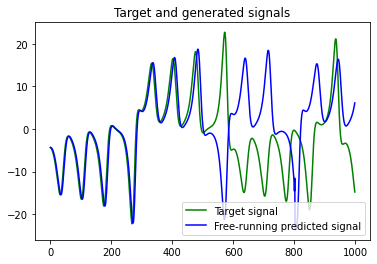

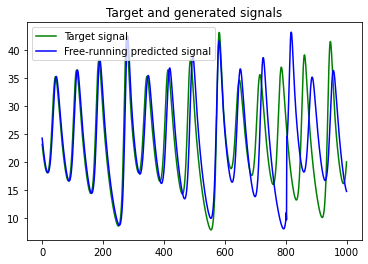

In [6]:
data = np.loadtxt('Lorenz.txt')
u = data[:, :] # input
y = data[1:, :] # output

# u = np.asarray((xs, ys, zs)).T[:-1,:]
# y = np.asarray((xs, ys, zs)).T[1:,:] # output

# hyperparameters
trainLen = 5000
testLen = 1000
initLen = 500 # washout phase
rho = 0.9 # spectral radius
sigma = 0.5 # input scale
lamda = 1e-7 # coefficient of regularization
inSize = outSize = 3
resSize = 500

# generate the ESN reservoir
np.random.seed(215125)
Win = (np.random.rand(resSize, 1+inSize * 2) - 0.5) * 2 * sigma # bias weight + input weights
W = np.random.rand(resSize, resSize) - 0.5  # W as N*N matrix

# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...')
W=W/max(abs(linalg.eig(W)[0]))*rho # eig return eigenvalues, eigenvectors
print('done.')

# allocated memory for the design (collected states) matrix
X = np.zeros((1+inSize+resSize, trainLen)) # matrix collects 1,u(t),r(t) in training
# set the corresponding target matrix directly
Yt = y[None, initLen:trainLen+initLen].squeeze().T # grab train data

# run the reservoir with the data and collect X
x = np.zeros((resSize, 1)) # r(t)
for t in range(trainLen+initLen):
    u_current = u[t].reshape((-1,1))
    Uk = np.array(lorenz_knowledge(u_current[0], u_current[1], u_current[2])).reshape((-1,1))
    x = np.tanh(np.dot(Win, np.vstack((1, u_current, Uk))) + np.dot(W, x)) # r(t+dt) = tanh[A*r(t) + Win*u(t)]
    if t >= initLen:
        # record the x in each step in training part
        X[:, t-initLen] = np.vstack((1, u_current, x)
                                    )[:, 0].reshape(resSize+inSize+1)

# ridge regression
Wout = np.dot( np.dot(Yt,X.T), linalg.inv( np.dot(X,X.T) + lamda*np.eye(1+inSize+resSize) ) ) # B = (X.T * X + lambda * I) ^ -1 * X.T * y

# run the trained ESN in a generative mode. no need to initialize here,
# because x is initialized with training data and we continue from there.
Y = np.zeros((outSize, testLen))
u_current = u[trainLen+initLen-1].reshape((-1,1))
for t in range(testLen):
    Uk = np.array(lorenz_knowledge(u_current[0], u_current[1], u_current[2])).reshape((-1,1))
    x = np.tanh(np.dot(Win, np.vstack((1, u_current, Uk))) + np.dot(W, x)) # r(t+dt) = tanh[A*r(t) + Win*u(t)]
    Y[:, t] = np.dot(Wout, np.vstack((1, u_current, x))).squeeze() # record the estimated u(t)
    u_current = Y[:, t].reshape((-1,1))

# compute MSE for the first errorLen time steps
errorLen = testLen
nmse = sum(np.square(y[trainLen+initLen+1:trainLen+initLen+errorLen+1] - Y[:, 0:errorLen].T)) / errorLen / np.std(y[trainLen+initLen+1:trainLen+initLen+errorLen+1]) / np.std(y[trainLen+initLen+1:trainLen+initLen+errorLen+1])
print('nmse:',nmse)

# plot some signals
for i in range(inSize):
    plt.figure(1).clear()
    plt.plot(y[trainLen+initLen+1:trainLen+initLen+testLen+1, i], 'g')
    plt.plot(Y.T[:, i], 'b')
    plt.title('Target and generated signals')
    plt.legend(['Target signal', 'Free-running predicted signal'])
    plt.show()

# Reservoir only

Computing spectral radius...
done.
nmse: [0.36075158 0.4750589  0.14463404]


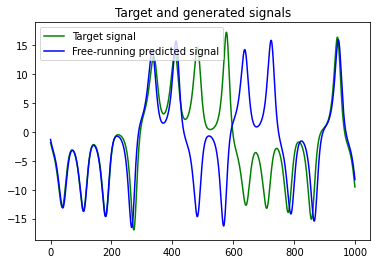

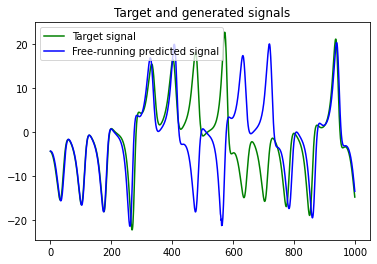

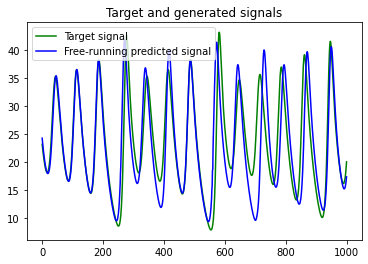

In [7]:
data = np.loadtxt('Lorenz.txt')
u = data[:, :] # input
y = data[1:, :] # output

# u = np.asarray((xs, ys, zs)).T[:-1,:]
# y = np.asarray((xs, ys, zs)).T[1:,:] # output

# hyperparameters
trainLen = 5000
testLen = 1000
initLen = 500 # washout phase
rho = 0.9 # spectral radius
sigma = 0.5 # input scale
lamda = 1e-7 # coefficient of regularization
inSize = outSize = 3
resSize = 500

# generate the ESN reservoir
np.random.seed(215125)
Win = (np.random.rand(resSize, 1+inSize) - 0.5) * 2 * sigma # bias weight + input weights
W = np.random.rand(resSize, resSize) - 0.5  # W as N*N matrix

# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...')
W=W/max(abs(linalg.eig(W)[0]))*rho # eig return eigenvalues, eigenvectors
print('done.')

# allocated memory for the design (collected states) matrix
X = np.zeros((1+inSize+resSize, trainLen)) # matrix collects 1,u(t),r(t) in training
# set the corresponding target matrix directly
Yt = y[None, initLen:trainLen+initLen].squeeze().T # grab train data

# run the reservoir with the data and collect X
x = np.zeros((resSize, 1)) # r(t)
for t in range(trainLen+initLen):
    u_current = u[t]
    x = np.tanh(np.dot(Win, np.vstack((1, u_current[:,np.newaxis]))) + np.dot(W, x)) # r(t+dt) = tanh[A*r(t) + Win*u(t)]
    if t >= initLen:
        # record the x in each step in training part
        X[:, t-initLen] = np.vstack((1, u_current[:,np.newaxis], x)
                                    )[:, 0].reshape(resSize+inSize+1)

# ridge regression
Wout = np.dot( np.dot(Yt,X.T), linalg.inv( np.dot(X,X.T) + lamda*np.eye(1+inSize+resSize) ) ) # B = (X.T * X + lambda * I) ^ -1 * X.T * y

# run the trained ESN in a generative mode. no need to initialize here,
# because x is initialized with training data and we continue from there.
Y = np.zeros((outSize, testLen))
u_current = u[trainLen+initLen-1]
for t in range(testLen):
    x = np.tanh(np.dot(Win, np.vstack((1, u_current[:,np.newaxis]))) + np.dot(W, x)) # r(t+dt) = tanh[A*r(t) + Win*u(t)]
    Y[:, t] = np.dot(Wout, np.vstack((1, u_current[:,np.newaxis], x))).squeeze() # record the estimated u(t)
    u_current = Y[:, t]

# compute MSE for the first errorLen time steps
errorLen = testLen
nmse = sum(np.square(y[trainLen+initLen+1:trainLen+initLen+errorLen+1] - Y[:, 0:errorLen].T)) / errorLen / np.std(y[trainLen+initLen+1:trainLen+initLen+errorLen+1]) / np.std(y[trainLen+initLen+1:trainLen+initLen+errorLen+1])
print('nmse:',nmse)

# plot some signals
for i in range(inSize):
    plt.figure(1).clear()
    plt.plot(y[trainLen+initLen+1:trainLen+initLen+testLen+1, i], 'g')
    plt.plot(Y.T[:, i], 'b')
    plt.title('Target and generated signals')
    plt.legend(['Target signal', 'Free-running predicted signal'])
    plt.show()